In [53]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

## Data Exploration

In [54]:
class SignalProcessor:
    def __init__(self, signal_path: str, info_path: str, chunks: int = 1024):
        """
        Initialize SignalProcessor
        Parameters:
        - signal_file_path (str): Path to the raw signal file.
        - info_file_path (str): Path to the raw info file.
        """
        self.signal_path = signal_path
        self.info_path = info_path
        self.chunks = chunks

        self.signal_data = self._load_signal_data()
        self.info_data = self._load_info_data()

    def _load_signal_data(self):
        """
        Load raw signal data from the specified file.
        Returns:
        - signal_data (numpy.ndarray): Loaded signal data reshaped into chunks of self.chunks.
        """
        with open(self.signal_path, 'rb') as signal_file:
            signal_data = np.fromfile(signal_file, dtype=np.uint8)
            signal_data = signal_data.reshape(-1, self.chunks)
        return signal_data
    
    def _load_info_data(self):
        """
        Load raw info data from the specified file.
        Returns:
        - info_data (numpy.ndarray): Loaded info data.
        """
        with open(self.info_path, 'rb') as info_file:
            info_data = np.fromfile(info_file, dtype=np.float32)
        return info_data
    
    def plot_signals(self, num_signals=50):
        """
        Plot a subset of signals.
        Parameters:
        - num_signals (int): Number of signals to visualize.
        """
        _, axs = plt.subplots(10, 5, figsize=(20, 25))
        axs = axs.flatten()
        for i in range(min(num_signals, len(self.signal_data))):
            axs[i].plot(self.signal_data[i])
            axs[i].set_title(f'Signal {i + 1}')
        plt.tight_layout()
        plt.show()

    # The info section provides details on the signals: length of the populated vector, 
    # number of peaks, and tuples with peak position, peak height and width. 
    # n_peaks = 0 → 2 + 0 = 2 values
    # n_peaks = 3 → 2 + (3 × 3) = 11 values
    def parse_info(self):
        parsed = []
        i = 0
        signal_id = 0

        while i < len(self.info_data):
            length = int(self.info_data[i])
            n_peaks = int(self.info_data[i + 1])
            i += 2

            # Init a base dict
            entry = {
                "signal_id": signal_id,
                "length": length,
                "n_peaks": n_peaks,
                "pos_1": None, "height_1": None, "width_1": None,
                "pos_2": None, "height_2": None, "width_2": None,
                "pos_3": None, "height_3": None, "width_3": None,
            }

            if n_peaks == 0:
                parsed.append(entry)
                i += 9 # skip directly to the next signal
            elif n_peaks > 0:
                # Populate at maximum of 3 peaks
                for p in range(min(n_peaks, 3)):
                    pos = float(self.info_data[i])
                    height = float(self.info_data[i + 1])
                    width = float(self.info_data[i + 2])
                    entry[f"pos_{p+1}"] = pos
                    entry[f"height_{p+1}"] = height
                    entry[f"width_{p+1}"] = width
                i += n_peaks * 3
                if n_peaks == 1:
                    i += 6
                elif n_peaks == 2:
                    i += 3
                elif n_peaks == 3:
                    pass

            parsed.append(entry)
            signal_id += 1

        df = pl.DataFrame(parsed)
        return df


    def visualize_info(self):
        """Show parsed info as a Polars DataFrame."""
        df = self.parse_info()
        pl.Config.set_tbl_rows(200)
        pl.Config.set_tbl_cols(12)
        print(df)


signal_processor = SignalProcessor("../data/signal.raw", "../data/info.raw")
        

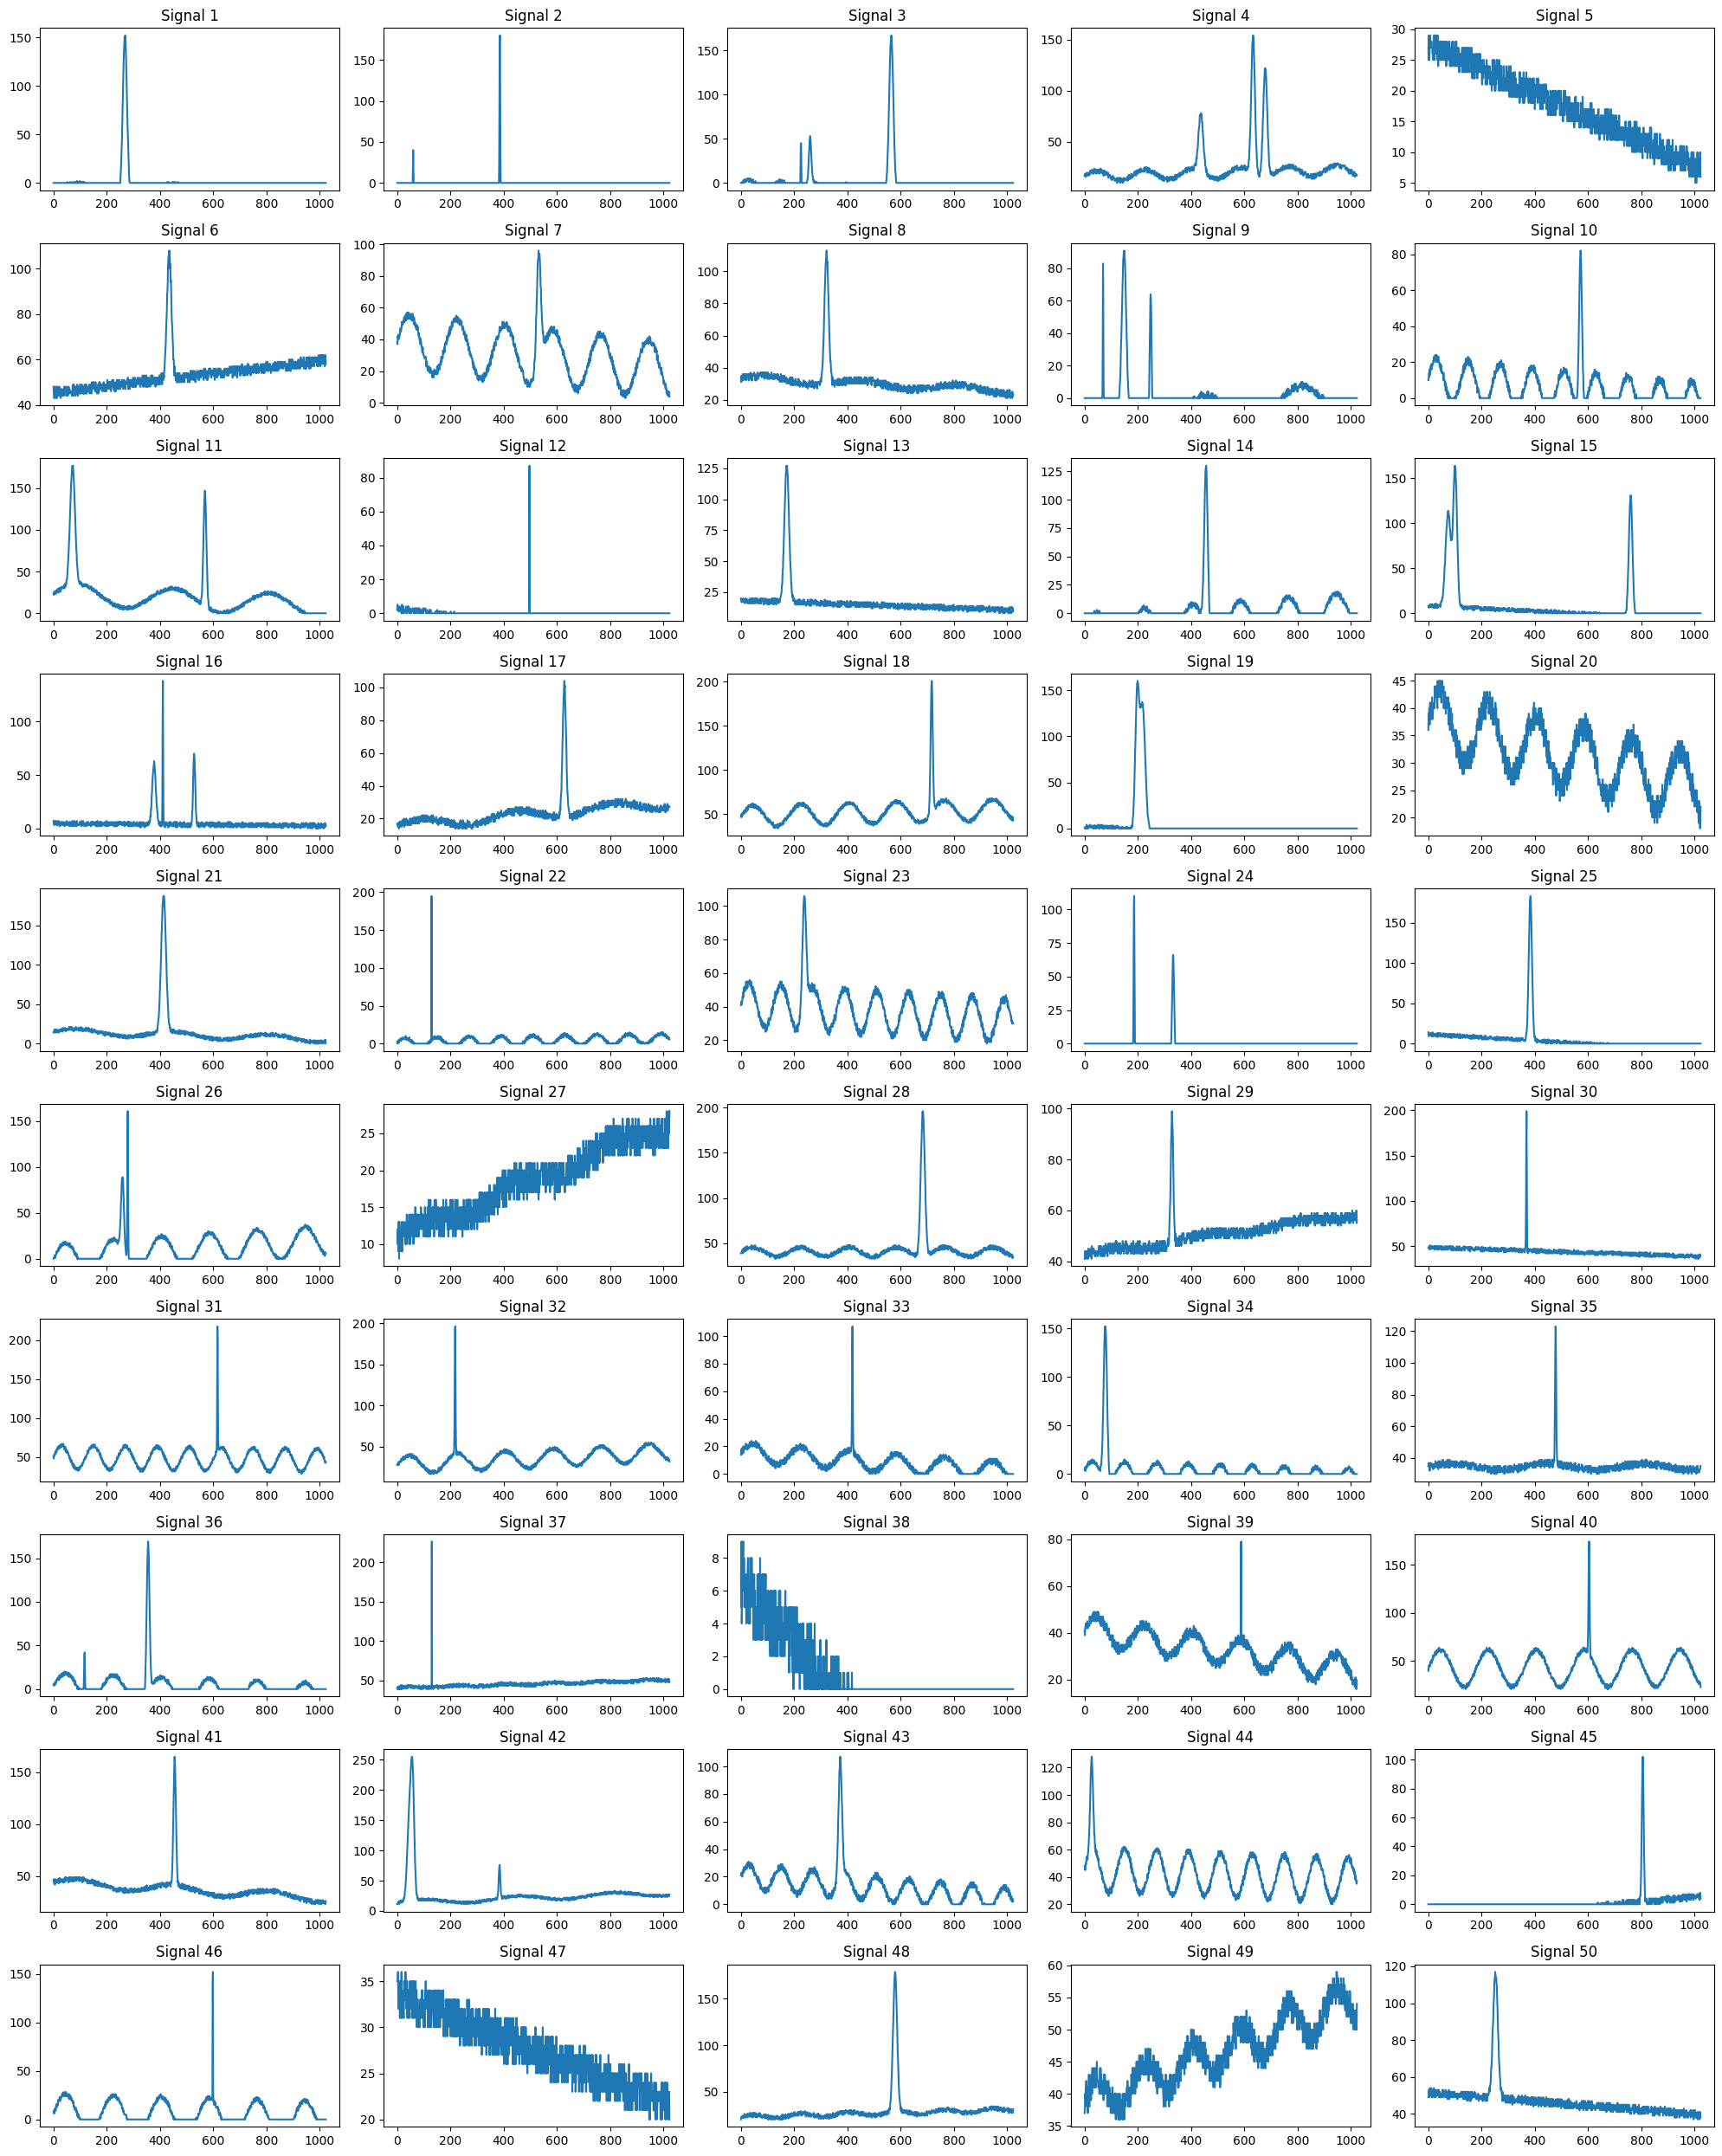

In [55]:
signal_processor.plot_signals()

In [56]:
signal_processor.visualize_info()

shape: (54_944, 12)
┌────────┬────────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ signal ┆ length ┆ n_peak ┆ pos_1 ┆ heigh ┆ width ┆ pos_2 ┆ heigh ┆ width ┆ pos_3 ┆ heigh ┆ width │
│ _id    ┆ ---    ┆ s      ┆ ---   ┆ t_1   ┆ _1    ┆ ---   ┆ t_2   ┆ _2    ┆ ---   ┆ t_3   ┆ _3    │
│ ---    ┆ i64    ┆ ---    ┆ f64   ┆ ---   ┆ ---   ┆ f64   ┆ ---   ┆ ---   ┆ f64   ┆ ---   ┆ ---   │
│ i64    ┆        ┆ i64    ┆       ┆ f64   ┆ f64   ┆       ┆ f64   ┆ f64   ┆       ┆ f64   ┆ f64   │
╞════════╪════════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ 0      ┆ 610    ┆ 1      ┆ 268.2 ┆ 165.6 ┆ 7.799 ┆ null  ┆ null  ┆ null  ┆ null  ┆ null  ┆ null  │
│        ┆        ┆        ┆ 59369 ┆ 57379 ┆ 758   ┆       ┆       ┆       ┆       ┆       ┆       │
│ 1      ┆ 847    ┆ 2      ┆ 385.5 ┆ 197.1 ┆ 1.325 ┆ 385.5 ┆ 197.1 ┆ 1.325 ┆ null  ┆ null  ┆ null  │
│        ┆        ┆        ┆ 81116 ┆ 77826 ┆ 141   ┆ 81116 ┆ 77826 ┆ 14